In [1]:
%matplotlib inline
import pprint
pp = pprint.PrettyPrinter(indent=2)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = [10, 5]

import numpy as np
import torch
from patter import ModelFactory
from patter.data import AudioSegment
from patter.decoder import GreedyCTCDecoder
from patter.data.features import PerturbedSpectrogramFeaturizer

WARN: CTCLoss not imported. Use only for inference.


### Load model
The ModelFactory class is responsible for reading a serialized model file, and initializing an instance
of the correct type of model (e.g. DeepSpeech2 or its variants, Wav2Letter, etc). The optional keyword
argument `include_package`, when True, returns a second object which is a dictionary of additional
model metadata. It is not necessary if using the model for training or decoding. The contents of the
dictionary are only useful for introspection into how the model was created and its performance.

In [2]:
#model = ModelFactory.load("../../models/librispeech_pretrained_patter.pt")
model, package = ModelFactory.load("../../models/librispeech_pretrained_patter.pt", include_package=True)

# put model in evaluation mode (crucial!)
model.eval()

In [3]:
print(model)

DeepSpeechOptim(
  (conv): Sequential(
    (0.cnn): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
    (0.batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (0.act): Hardtanh(min_val=0, max_val=20)
    (1.cnn): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
    (1.batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (1.act): Hardtanh(min_val=0, max_val=20)
  )
  (rnn): DeepBatchRNN(
    (batch_norm): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
    (rnns): Sequential(
      (0): BatchRNN(
        (rnn): GRU(672, 800, bias=False, bidirectional=True)
      )
      (1): BatchRNN(
        (batch_norm): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
        (rnn): GRU(800, 800, bias=False, bidirectional=True)
      )
      (2): BatchRNN(
        (batch_norm): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True)
        (rnn): GRU(800, 800, bias=False, bidirectional=True)
      )
      (3): BatchRNN(
        

### Set up Featurizer
The model configuration includes what featurization is required to convert the audio to a format acceptable to it.
A patter featurizer is responsible for reading that configuration, then reading in audio from its on-disk format
and returning a tensor ready for the model.


In [4]:
featurizer = PerturbedSpectrogramFeaturizer.from_config(model.input_cfg)

### Set up Decoder
Either a simple greedy decoder or a more complicated beam decoder (with or without language model) can
be used to convert the acoustic model outputs to the final transcription. Initialization is accomplished
similarly either way, though more configuration is required for the Beam Decoder (see source code).

In [5]:
decoder = GreedyCTCDecoder(model.labels, blank_index=0)

## Transcribe audio
To transcribe audio, it must be loaded from disk and featurized. The input features are then passed through the
acoustic model. The output of the acoustic model must then be decoded using a properly initialized decoder.

In [6]:
audio_path = "../../data/sample/1089-134691-0003.wav"
segment = AudioSegment.from_file(audio_path, target_sr=model.input_cfg['sample_rate'])

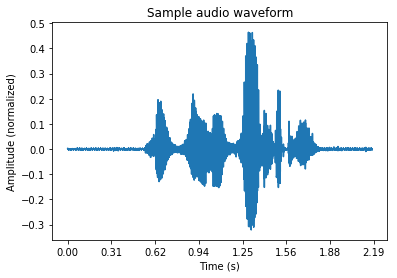

In [7]:
# plot the audio waveform
plt.plot(segment.samples)
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.2f" % (x/model.input_cfg['sample_rate'])))
plt.title("Sample audio waveform")
plt.ylabel("Amplitude (normalized)")
plt.xlabel("Time (s)")
plt.show()

In [8]:
features = featurizer.process_segment(segment)

Note: there is a bit of leakage in the above in terms of end-user knowledge. We have to manually set the `target_sr`
for the segment in this case. The below call to `featurizer.process()` eliminates this leakage and is equivalent
to the separate loading and featurization steps shown above.

In [9]:
features = featurizer.process(audio_path)

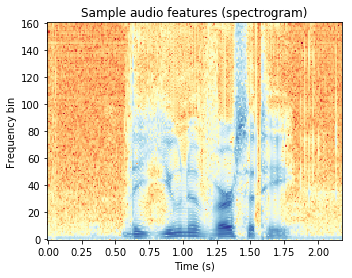

In [10]:
# plot the features (in this case, a spectrogram)
plt.imshow(features.numpy(), cmap="RdYlBu", origin="lower")
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.2f" % (x*model.input_cfg['window_stride'])))
plt.title("Sample audio features (spectrogram)")
plt.ylabel("Frequency bin")
plt.xlabel("Time (s)")
plt.show()

In [11]:
# This adds two singleton dimensions to the feature tensor.
# The model expects input in the form (1, batch_size, feature_size, max_seq_len)
features = features.unsqueeze(0).unsqueeze(0)
seq_len = torch.IntTensor([features.size(3)])

# run model
output, output_len = model(torch.autograd.Variable(features, volatile=True),
                           torch.autograd.Variable(seq_len, volatile=True))

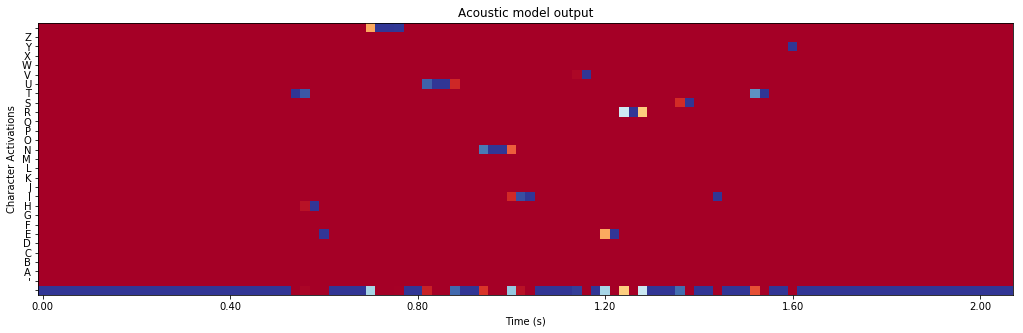

In [12]:
fig1 = plt.figure(figsize=(20,5))
ax = fig1.add_subplot(1,1,1)

def idx_to_label(x, pos):
    try:
        return model.labels[int(x)]
    except:
        return ""
plt.yticks(np.arange(0,len(model.labels)))
ax.yaxis.set_major_formatter(plt.FuncFormatter(idx_to_label))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.2f" % (x*2*model.input_cfg['window_stride'])))
ax.imshow(output.data.squeeze().numpy().T, cmap="RdYlBu",origin="lower", interpolation="none")
plt.title("Acoustic model output")
plt.xlabel("Time (s)")
plt.ylabel("Character Activations")
plt.show()

In [13]:
### Decode acoustic model output
output = output.transpose(0, 1) # decoder requires [batch_size, seq_len, character_classes]
transcript, offsets, scores = decoder.decode(output.data, output_len.data, num_results=1)

In [14]:
print("Top-rated final transcript for first utterance in batch:")
print(transcript[0][0])

Top-rated final transcript for first utterance in batch:
THE UNIVERSITY


### Appendix
**Note:** If you want to run the above on a GPU, the model and Variables must be moved to the GPU, i.e.:

```python
model = model.cuda()

features = torch.autograd.Variable(features, volatile=True).cuda()
seq_len = torch.autograd.Variable(seq_len, volatile=True).cuda()
```

and the output will have to be moved back to the CPU prior to decoding, i.e.:

```python
output = output.cpu()
```